In [1]:
from shutil import rmtree
from os.path import isdir
from os import mkdir
from IPython.core.display import set_matplotlib_formats
from sympy import solve, symbols, Eq
from sympy.physics.units import kilo, milli
from sympy.physics.units import convert_to
from sympy.physics.units import ohms, amperes, volts
import ltspice
import platform
import ahkab
import pylab as plt
from IPython import get_ipython

files_directory = "files\\"
fig_directory = "..\\resource\\figures\\"
import matplotlib.pyplot as plot
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Primero preparamos un lugar para ubicar todo los archivos que genere el Notebook

W: Locale appears not set! please export LANG="en_US.UTF-8" or equivalent, 
W: or ahkab's unicode support is broken.


In [2]:
files_directory = "files\\"
# si el directorio existe se elimina con su contenido
if isdir(files_directory):
    rmtree(files_directory)
# crea un directorio para alojar todo los archivos que se generen
mkdir(files_directory)

fig_directory = "..\\resource\\figures\\"
# si el directorio existe se elimina con su contenido
if isdir(fig_directory):
    rmtree(fig_directory)
# crea un directorio para alojar todo los archivos que se generen
mkdir(fig_directory)


 ## Carrera de condensadores

 Ahora tenemos un circuito con dos condensadores en paralelo:

 ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/condensadores%20en%20paralelo.svg?sanitize=true)

 #### **Pregunta:**

 > Crea el netlist de este circuito e identifica qué condensador se satura primero. Dibuja la evolución de la intensidad en ambas ramas de manera simultánea. [Aquí](https://matplotlib.org/gallery/api/two_scales.html) tienes un ejemplo de cómo se hace esto en Matplotlib. Recuerda que para que Ahkab nos devuelva la corriente en una rama, debe de estar presente una pila. Si es necesario, inserta pilas virtuales de valor nulo (cero voltios), tal y como hemos comentado antes. Grafica también los voltajes (en otra gráfica, pero que aparezcan juntos).

 #### **Respuesta:**

 El condensador que antes se saturará es C2, puesto que su capacidad es menor

In [3]:
%%writefile "files\carrera_de_condensadores.ckt"
* Carga condensador
v0 1 0 type=vdc vdc=10
r1 0 2 3k
c1 2 3 47u ic=0
v1dummy 3 1 type=vdc vdc=0
c2 2 4 22u ic=0
v2dummy 4 1 type=vdc vdc=0
.op
.tran tstep=0.01 tstart=6.5 tstop=7.5 uic=0
.end


Writing files\carrera_de_condensadores.ckt


 ### Procesamos el circuito con `Ahkab` y extraemos los datos.

In [4]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit("files\carrera_de_condensadores.ckt")
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los análisis `.dc` y/o `.tran` si lo hay.
for análisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    análisis['outfile'] = files_directory + "simulación_" + análisis['type'] + ".tsv"

  Ejecutamos la simulación

In [5]:
resultados = ahkab.run(netlist, lista_de_análisis)
print(resultados['op'])


Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting transient analysis: 
Selected method: TRAP
Solving...  done.
Average time step: 0.00900901
OP simulation results for '* carga condensador'(netlist files\carrera_de_condensadores.ckt).
Run on 2020-12-20 15:40:26, data file None.
Variable    Units      Value    Error    %
----------  -------  -------  -------  ---
V1          V             10   -1e-11    0
V2          V              0    0        0
V3          V             10   -1e-11    0
V4          V             10   -1e-11    0
I(V0)       A              0    0        0
I(V1DUMMY)  A              0    0        0
I(V2DUMMY)  A              0    0        0


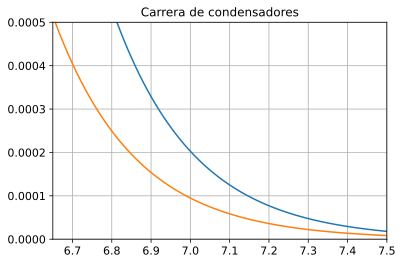

In [6]:
figura = plt.figure()
plt.title("Carrera de condensadores")
plt.xlim(6.65, 7.5)
plt.ylim(0.0, 0.0005)
plt.grid()
plt.plot(list(map(lambda x: -x if x < 0 else x, resultados['tran']['T'])), 
    list(map(lambda x: -x if x < 0 else x, resultados['tran']['I(V1DUMMY)'])), 
    label="Intensidad en C1")
plt.plot(list(map(lambda x: -x if x < 0 else x, resultados['tran']['T'])), 
    list(map(lambda x: -x if x < 0 else x, resultados['tran']['I(V2DUMMY)'])), 
    label="Intensidad en C2")


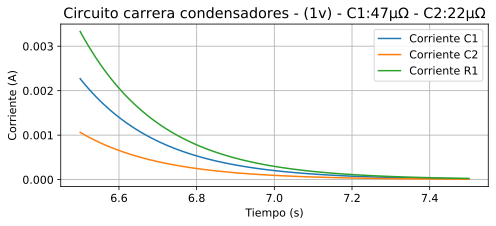

In [7]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

tiempo = resultados['tran']['T']
f = lambda x: -x if x < 0 else x
i_C1 = resultados['tran']['I(V1DUMMY)']
i_C1 = list(map(f, i_C1))
i_C2 = resultados['tran']['I(V2DUMMY)']
i_C2 = list(map(f, i_C2))
i_R1 = resultados['tran']['I(V0)']
i_R1 = list(map(f, i_R1))

plot.rcParams['figure.figsize'] = [6.4*1.1, 4.8*1.2]
plot.rcParams['font.size'] = 12
# plot.rcParams['legend.fontsize'] = 'large'
# plot.rcParams['figure.titlesize'] = 'medium'
fig, ax = plot.subplots()
plot.title('Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

axc1 = plot.subplot(211)
line_iC1, = axc1.plot(tiempo, i_C1)
line_iC1.set_label('Corriente C1')
# line_iC1.set_c('tab:brown')
axc1.set(xlabel='Tiempo (s)', 
    ylabel='Corriente (A)', 
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

axc2 = plot.subplot(211)
line_iC2, = axc2.plot(tiempo, i_C2)
line_iC2.set_label('Corriente C2')
# line_iC2.set_c('tab:purple')
axc2.set(xlabel='Tiempo (s)', 
    ylabel='Corriente (A)', 
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

axc3 = plot.subplot(211)
line_iR1, = axc3.plot(tiempo, i_R1)
line_iR1.set_label('Corriente R1')
# line_iR1.set_c('tab:red')
axc3.set(xlabel='Tiempo (s)', 
    ylabel='Corriente (A)', 
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

plot.legend()
plot.grid(True)
plot.tight_layout()
plot.show()


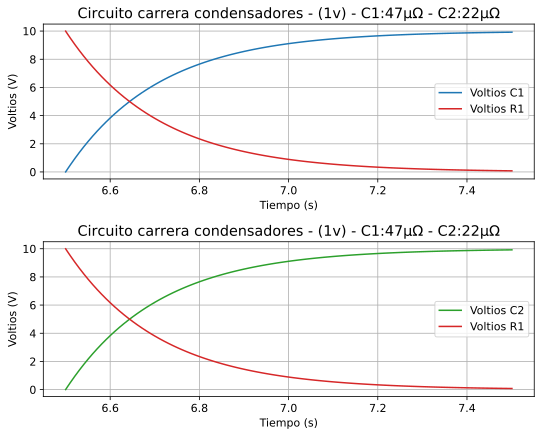

In [8]:
tiempo = resultados['tran']['T']
v_R1 = resultados['tran']['V2']
v_C1 = resultados['tran']['V3']
v_C2 = resultados['tran']['V4']
f = lambda a, b: a - b
v_C1 = list(map(f, v_C1, v_R1))
v_C2 = list(map(f, v_C2, v_R1))

plot.rcParams['figure.figsize'] = [6.4*1.2, 4.8*1.3]
plot.rcParams['font.size'] = 12
# plot.rcParams['legend.fontsize'] = 'large'
# plot.rcParams['figure.titlesize'] = 'medium'
fig, ax = plot.subplots()
plot.title('Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

axv1 = plot.subplot(211)
line_vC1, = axv1.plot(tiempo, v_C1)
line_vC1.set_label('Voltios C1')
line_vC1.set_c('tab:blue')
axv1.set(xlabel='Tiempo (s)', ylabel='Voltios (V)',
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')
axv1.grid(True)

axv3 = plot.subplot(211)
line_vR1, = axv3.plot(tiempo, v_R1)
line_vR1.set_label('Voltios R1')
line_vR1.set_c('tab:red')
axv3.set(xlabel='Tiempo (s)', ylabel='Voltios (V)',
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

plot.legend()

axv2 = plot.subplot(212)
line_vC2, = axv2.plot(tiempo, v_C2)
line_vC2.set_label('Voltios C2')
line_vC2.set_c('tab:green')
axv2.set(xlabel='Tiempo (s)', ylabel='Voltios (V)',
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

axv3 = plot.subplot(212)
line_vR1, = axv3.plot(tiempo, v_R1)
line_vR1.set_label('Voltios R1')
line_vR1.set_c('tab:red')
axv3.set(xlabel='Tiempo (s)', ylabel='Voltios (V)',
    title='Circuito carrera condensadores - ($\mathrm{1v}$) - C1:$\mathrm{47\mu\Omega}$ - C2:$\mathrm{22\mu\Omega}$')

plot.legend()
plot.grid(True)
plot.tight_layout()
plt.savefig("test.svg", format="svg")
# plot.show()

plot.rcParams['figure.figsize'] = [6.4, 4.8]

# {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}









 **Ejercicio premium:** Repite la simulación con LTspice (invocándolo como comando externo, leyendo los datos de un fichero `.raw` y volviendo a graficar con Matplotlib.

 ## Circuitos en corriente alterna

 ** Ejercicio:** Simula este circuito con LTspice y representa el voltaje y la intensidad en función del tiempo. Traduce este ejercicio a la versión Spice de Akhab y haz la misma representación. Ahkab utiliza otra sintaxis para expresar la corriente alterna. Esta está descrita en la [documentación](https://ahkab.readthedocs.io/en/latest/help/Netlist-Syntax.html#id24).

In [9]:
get_ipython().run_cell_magic('writefile', '"corriente alterna.net"',
                             '* Circuito en corriente alterna\nv1 1 0 sin(0 120 60 0 0)\nr1 0 1 10k\n.tran 1\n.end')



Overwriting corriente alterna.net


In [10]:
lts "corriente alterna.net"


SyntaxError: invalid syntax (<ipython-input-10-cdd2a282dd70>, line 1)